# Social information for friendship network

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as colors
import timeit
import math
import random
import feather as ft

## Know something fundamentals of friendship network in Weeplace datset

In [ ]:
df_friend = pd.read_csv('data/weeplace_friends.csv')
df_wp = ft.read_dataframe('data/weeplace_checkins_without_loc_NA.feather') # it is the dataset without NA location

In [ ]:
df_wp_origin = pd.read_csv('data/weeplace_checkins.csv')  # this is original Weeplace dataset without any processing, including some NA location

In [ ]:
df_wp_origin = df_wp_origin.dropna(subset=["placeid",'userid', 'datetime'])
print(len(set(df_wp_origin['userid'].tolist())), len(set(df_wp['userid'].tolist())))

Check all the users in friendship network whether they have mobility data in Weeplace dataset

In [ ]:
TrueUser1 = set(df_friend['userid1'].tolist())
TrueUser2 = set(df_friend['userid2'].tolist())
UsedUser = set(df_wp['userid'].tolist())

if UsedUser.issubset(TrueUser1) & UsedUser.issubset(TrueUser2):
    print('All used users appear in the true friendship network')

In [ ]:
print(len(TrueUser1), len(TrueUser2), len(UsedUser))

It appears that the true friendship has more users than used mobility data, that is to say, some of users in friendship network have no mobility infomration. The following `TrueUser1 - UsedUser` shows the users appear in frienship network (user1) but do not have mobility information, similar meaning in `TrueUser2 - UsedUser`.

In [ ]:
TrueUser1 - UsedUser

In [ ]:
TrueUser2 - UsedUser

In [ ]:
print('There are ', len(TrueUser1 - UsedUser), 'users (user1) in true friendship who do not have mobility data information')

In [ ]:
print('There are ', len(TrueUser2 - UsedUser), 'users (user2) in true friendship who do not have mobility data information')

Therefore, we remove all the users in friendship network who do not have mobility information

In [ ]:
df_friend_used = df_friend[df_friend['userid1'].isin(UsedUser) & df_friend['userid2'].isin(UsedUser)]

In [ ]:
print('We remove', str(df_friend.shape[0] - df_friend_used.shape[0]), 'records in friendship network with no mobility data')

In [ ]:
num_friend = df_friend.groupby('userid1').count()['userid2'].reset_index(name='count').sort_values('count', ascending=False)
num_friend

In [ ]:
num_friend_used = df_friend_used.groupby('userid1').count()['userid2'].reset_index(name='count').sort_values('count', ascending=False)
num_friend_used 

In [ ]:
print('In fact, we remove', str(num_friend.shape[0] - num_friend_used.shape[0]), 'users in friendship network')

In [ ]:
from scipy.optimize import curve_fit

# exponential fit for the number of friends
def exp_fit(rdata, A, alpha):
    return A*rdata**(-alpha)

In [ ]:
NumFriendsHist = np.histogram(num_friend[['count']],density=True, bins=100)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,7.5))

num_friend[['count']].plot.hist(bins=500, density=True, ax=ax1, histtype='step', color='red')
num_friend_used[['count']].plot.hist(bins=500, density=True, ax=ax1, histtype='step', color='blue')
ax1.set(xlabel='Num Friends', ylabel='Frequency', xscale='log', yscale='log',
       title='Frequency (pdf) of Number of Friends a user has')
ax1.legend(['Full Friendship Network', 'Flitered Friendship Network'])

num_friend[['count']].plot.hist(bins=500, density=True, ax=ax2, histtype='step', color='red', cumulative=True)
num_friend_used[['count']].plot.hist(bins=500, density=True, ax=ax2, histtype='step', color='blue', cumulative=True)
ax2.set(xlabel='Num Friends', ylabel='Cumulative Frequency', xscale='log', yscale='log',
       title='Cumulative Frequency (cdf) of Number of Friends a user has')
ax2.legend(['Full Friendship Network', 'Flitered Friendship Network'], loc=8)

plt.show()

After filtering, we only have less users, but from the view of hist fit (log view), it is acceptable.

## Compute entropy for all users

In [ ]:
from entropy_functions import shannon_entropy, entropy, cross_entropy
import pickle

* Notice: now we only consider user's visitation as the **time-ordered sequential** rather than **temporal sequential**, and then compute shannon entropy and LZ-entropy

In [ ]:
""" Extract time-ordered placeid sequential for all users"""
num_used_users = len(UsedUser)

# # this placeid store only include all the users who appear in the true friendship network
# placeid_store = np.empty(num_used_users, dtype=object)

# for i in range(num_used_users):
#     placeid_store[i] = df_wp[df_wp['userid'] ==list(UsedUser)[i]].set_index('datetime').sort_index()['placeid'].to_list()

# # save pickle file
# pickle_out = open("placeid.pickle", "wb")
# pickle.dump(placeid_store, pickle_out)
# pickle_out.close()

# read picle file
pickle_in = open("placeid_store.pickle", "rb")
placeid_store = pickle.load(pickle_in)

Now we can compute shanon entropy and LZ-entropy for all the users and plot the histograms

In [172]:
user_shannon_entropy = [shannon_entropy(placeid_store[i]) for i in range(num_used_users)]

In [173]:
user_LZ_entropy = [entropy(placeid_store[i]) for i in range(num_used_users)]

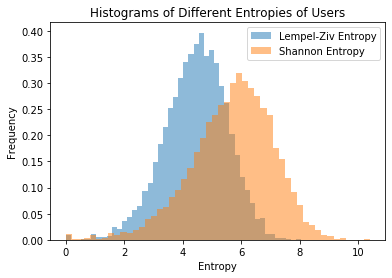

In [177]:
plt.title('Histograms of Different Entropies of Users')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.hist(user_LZ_entropy,bins = 50,density = True, label = 'Lempel-Ziv Entropy',alpha=.5)
plt.hist(user_shannon_entropy ,bins = 50,density = True, label = 'Shannon Entropy',alpha=.5)
plt.legend()
plt.show()